In [86]:
import pymatgen as pmg
from pymatgen.io.vasp.outputs import Outcar
from pymatgen.electronic_structure.core import Spin
import numpy as np

import pandas as pd

from os.path import expanduser
home = expanduser('~')

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


def format_ladder(orbitals, occu_matrix, spin=None):
    ladder = np.array(sorted(zip(np.diag(occu_matrix), orbitals), reverse=True))
    occu_ladder = ladder[:,0]
    orb_ladder = ladder[:,1]
    if spin == 1:
        row1 = '/\ Orbital:   '
        row2 = '/\ Occupation:'
    elif spin == -1:
        row1 = '\/ Orbital:   '
        row2 = '\/ Occupation:'
    for i in range(len(occu_ladder)):
        row1 = row1 + f'\t{orb_ladder[i]}'
        row2 = row2 + f'\t{occu_ladder[i]}'
    return row1 + '\n' + row2


def display_occu(odm, orbitals, order=None, print_ladder=True):
    up = odm[Spin.up]
    down = odm[Spin.down]
    
    ### Write header
    header = '\t'
    if order == None: order = range(5)
    for i in order:
        header = f'{header}{orbitals[i]}\t\t'
    print(header, end='')
    
    ### Write each row
    for i in order:
        print(f'\n{orbitals[i]}', end='\t')
        for j in order:
            entries = [np.round(up[i][j], 2), np.round(down[i][j], 2)]
            for k in range(2):
                if entries[k] == 0:
                    entries[k] = '----'
            print(f'{entries[0]} / {entries[1]}', end='\t')
    print('\n')
    if print_ladder:
        print(format_ladder(orbitals, up, spin=1))
        print()
        print(format_ladder(orbitals, down, spin=-1))
#         up_ladder = zip(np.diag(up), orbitals)
#         up_ladder =  sorted(up_ladder, reverse=True)
#         print(np.array(up_ladder).T)
#         print('\n')
        
#         dn_ladder = zip(np.diag(down), orbitals)
#         dn_ladder =  sorted(dn_ladder, reverse=True)
#         print(np.array(dn_ladder).T)
#         print('\n')
    

def print_occupations(iters, orbitals, n_with_U, order=None, atom_idx=0):
    odms = []
    for i, iter_1 in enumerate(iters):
            label = f'{iter_1}'
            outcar = Outcar(f'{PREFIX}-{label}{SUFFIX}')
            outcar.read_onsite_density_matrices()
            odm = outcar.data['onsite_density_matrices'][-n_with_U:] # we only want to odm from last iter
            odms.append(odm)
            print(f'##### {iter_1} #####')
            display_occu(odm[atom_idx], orbitals, order=order)
            print()

            
def parse_diag_occus(iters, orbitals, n_with_U, order=None, atom_idx=0, spin=-1):
    odms = []
    diag_occus = []
    for i, iter_1 in enumerate(iters):
        label = f'{iter_1}'
        ### jank fix for spin swapped run
        if label == 'exp_P4nmm_e249.5':
            print('activated')
            tmp_atom_idx = 6
        else:
            tmp_atom_idx = atom_idx
        ####################################
        outcar = Outcar(f'{PREFIX}-{label}{SUFFIX}')
        outcar.read_onsite_density_matrices()
        odm = outcar.data['onsite_density_matrices'][-n_with_U:] # we only want to odm from last iter
        odms.append(odm)
        
        # Diagonalized
        if spin == -1:
            occu_matrix = odm[tmp_atom_idx][Spin.down]
        elif spin == 1:
            occu_matrix = odm[tmp_atom_idx][Spin.up]
        else:
            print("Invalid spin, should be +/- 1")
            return
        diag_occu = np.diag(occu_matrix)
        diag_occu = [diag_occu[i] for i in order]
        diag_occus.append(diag_occu)
    ordered_orbitals = [orbitals[i] for i in order] 
    df = pd.DataFrame(diag_occus, columns=ordered_orbitals)
    df.insert(0, 'x', ITERS_2)
    return df


def plot_diag_occus(label, df, legend_labels, norm=None):
    fig = plt.figure(figsize=(6.5,3.5))
    x = df['x']
    if norm:
        for i in range(len(df)):
            df.iloc[i] = pd.concat([df.iloc[i][:1], df.iloc[i][1:]/sum(df.iloc[i][1:])*norm])    
    for i in range(len(legend_labels)):
        if legend_labels[i] in ['$d_{yz}$']:
            plt.plot(x, df[df.columns[i+1]], 'x--', label=legend_labels[i])
        elif legend_labels[i] in ['$d_{xz}$']:
            plt.plot(x, df[df.columns[i+1]], '+--', label=legend_labels[i])
        else:
            plt.plot(x, df[df.columns[i+1]], 'o-', label=legend_labels[i])
#     plt.xlabel('Electron Count')
    plt.xlabel('$U_{eff}$ (eV)')
    if norm: plt.ylabel('Normalized Occupancy')
    else:    plt.ylabel('Orbital Occupancy')
    plt.grid(1)
    plt.ylim(0,1.05)
#     plt.legend(bbox_to_anchor=(1, 1.3), ncol=5)
    plt.legend(ncol=5)
    plt.show()
    fig.savefig(f'diag-occu_{label}.png', dpi=300, bbox_inches='tight')
        
### Unrotated
orbitals_fancy = ['$d_{x^2 - y^2}$', '$d_{yz}$', '$d_{z^2 - r^2}$', '$d_{xz}$', '$d_{xy}$']
orbitals = ['d_x2-y2', 'd_yz', 'd_z2-r2', 'd_xz', 'd_xy']
order = [4, 1, 3, 2, 0]

### Rotated to align with VASP default (ligands along xyz)
rot_orbitals_fancy = ['$d_{xy}$', '$d_{yz}$', '$d_{z^2 - r^2}$', '$d_{xz}$', '$d_{x^2 - y^2}$']
rot_orbitals = ['d_xy', 'd_yz', 'd_z2-r2', 'd_xz', 'd_x2-y2']
rot_order =  [0, 1, 3, 2, 4] #ordering is just for cosmetics -- xz near yz



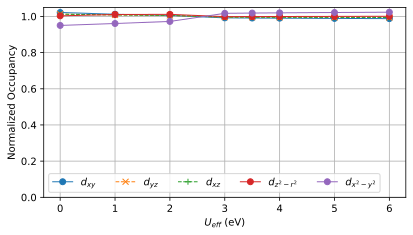

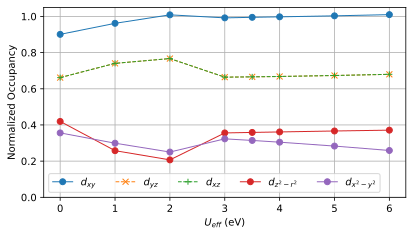

In [87]:
### eta
PREFIX = home + '/Projects/storage/anion-sub_BaCoS2/aligned-estruc/OUTCAR'
SUFFIX = ''

ITERS_1 = ['P4nmm']
ITERS_2 = [0,1,2,3,3.5,4,5,6]

for iter1 in ITERS_1:
    ITERS = [f'{iter1}_U{iter2}' for iter2 in ITERS_2]

    df = parse_diag_occus(ITERS, rot_orbitals,  n_with_U=8, order=rot_order, atom_idx=0, spin=1)
    plot_diag_occus('U', df, [rot_orbitals_fancy[i] for i in rot_order], norm=5)
    
    df = parse_diag_occus(ITERS, rot_orbitals,  n_with_U=8, order=rot_order, atom_idx=0, spin=-1)
    plot_diag_occus('U', df, [rot_orbitals_fancy[i] for i in rot_order], norm=3)

In [11]:
for i in range(1):
    print_occupations(ITERS, rot_orbitals,  n_with_U=8, order=rot_order, atom_idx=i)

# print_occupations(ITERS, orbitals,  n_with_U=8, order=order, atom_idx=0)

##### P4nmm_U0 #####
	d_xy		d_yz		d_xz		d_z2-r2		d_x2-y2		
d_xy	0.91 / 0.85	---- / ----	---- / ----	---- / 0.01	---- / ----	
d_yz	---- / ----	0.91 / 0.63	---- / ----	---- / ----	---- / ----	
d_xz	---- / ----	---- / ----	0.91 / 0.63	---- / ----	---- / ----	
d_z2-r2	---- / 0.01	---- / ----	---- / ----	0.9 / 0.4	---- / ----	
d_x2-y2	---- / ----	---- / ----	---- / ----	---- / ----	0.85 / 0.34	

/\ Orbital:   	d_xy	d_yz	d_xz	d_z2-r2	d_x2-y2
/\ Occupation:	0.9137	0.9054	0.9054	0.8971	0.8497

\/ Orbital:   	d_xy	d_yz	d_xz	d_z2-r2	d_x2-y2
\/ Occupation:	0.8536	0.627	0.627	0.3975	0.3374

##### P4nmm_U1 #####
	d_xy		d_yz		d_xz		d_z2-r2		d_x2-y2		
d_xy	0.92 / 0.88	---- / ----	---- / ----	---- / 0.01	---- / ----	
d_yz	---- / ----	0.92 / 0.68	---- / -0.01	---- / ----	---- / ----	
d_xz	---- / ----	---- / -0.01	0.92 / 0.68	---- / ----	---- / ----	
d_z2-r2	---- / 0.01	---- / ----	---- / ----	0.92 / 0.24	---- / ----	
d_x2-y2	---- / ----	---- / ----	---- / ----	---- / ----	0.88 / 0.27	

/\ Orbital:   	d